## Causal Uplift Modeling on Criteo Dataset - Visit Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

TEST_SIZE = 0.4
RANDOM_STATE = 42
PERCENT10 = True
TARGET_COL = "visit"

In [4]:
from sklift.datasets import fetch_criteo

data, outcome, treatment = fetch_criteo(
    target_col=TARGET_COL,
    treatment_col="exposure",
    return_X_y_t=True,
    data_home="../data/",
    download_if_missing=True,
    percent10=PERCENT10,
)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
    data,
    treatment,
    outcome,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
)
X_train.shape, X_test.shape, t_train.shape, t_test.shape, y_train.shape, y_test.shape

((838776, 12), (559184, 12), (838776,), (559184,), (838776,), (559184,))

In [6]:
y_train.value_counts(normalize=True)

visit
0    0.953089
1    0.046911
Name: proportion, dtype: Float64

In [7]:
y_test.value_counts(normalize=True)

visit
0    0.952887
1    0.047113
Name: proportion, dtype: Float64

In [8]:
t_train.value_counts(normalize=True)

exposure
0    0.969543
1    0.030457
Name: proportion, dtype: Float64

In [9]:
t_test.value_counts(normalize=True)

exposure
0    0.969109
1    0.030891
Name: proportion, dtype: Float64

## S-learner

In [10]:
from causalml.inference.meta import BaseSClassifier
from lightgbm import LGBMClassifier

model_s = BaseSClassifier(learner=LGBMClassifier())
model_s.fit(X_train, t_train, y_train)

[LightGBM] [Info] Number of positive: 39348, number of negative: 799428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 838776, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.046911 -> initscore=-3.011451
[LightGBM] [Info] Start training from score -3.011451


In [13]:
tau = model_s.predict(X_test).reshape(-1)

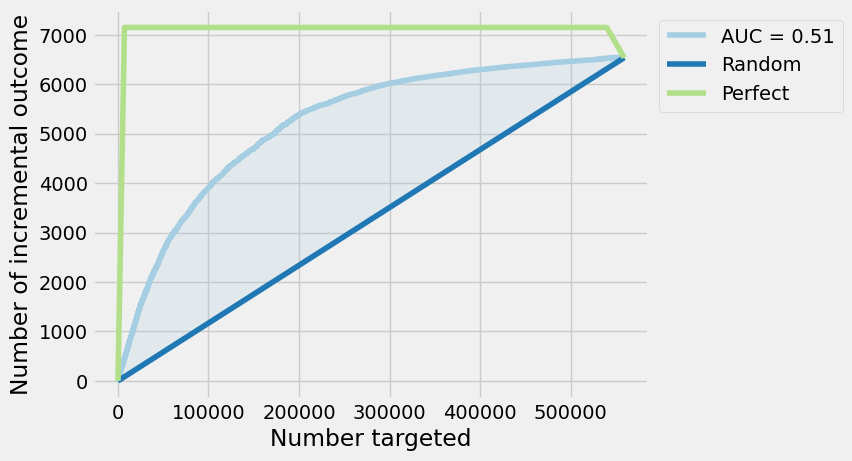

In [14]:
from src.curve import plot_qini_curve

plot_qini_curve(
    y_true=y_test,
    uplift=tau,
    treatment=t_test,
)

<Axes: title={'center': 'Uplift Bins'}, xlabel='Bin', ylabel='Actual Uplift Mean'>

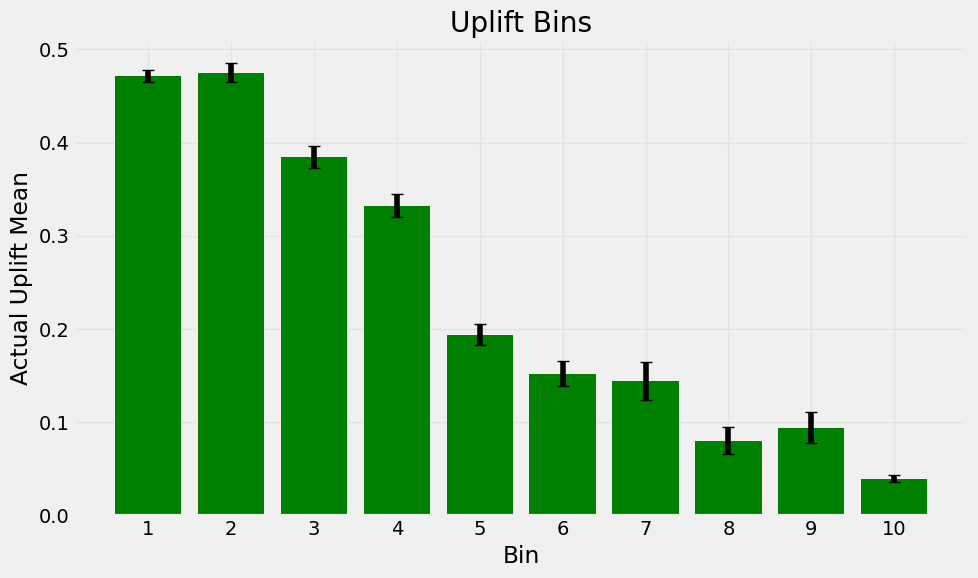

In [15]:

from src.bins import plot_uplift_bins

plot_uplift_bins(
    t=t_test,
    y=y_test,
    tau=tau,
)

## T-learner

In [85]:
from causalml.inference.meta import BaseTClassifier

model_t = BaseTClassifier(learner=LGBMClassifier())
model_t.fit(X_train, t_train, y_train)

[LightGBM] [Info] Number of positive: 2491, number of negative: 65275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 67766, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036759 -> initscore=-3.265925
[LightGBM] [Info] Start training from score -3.265925
[LightGBM] [Info] Number of positive: 881, number of negative: 1251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1749
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 12
[LightGBM] [Info] [bina

In [ ]:
tau = model_t.predict(X_test).reshape(-1)

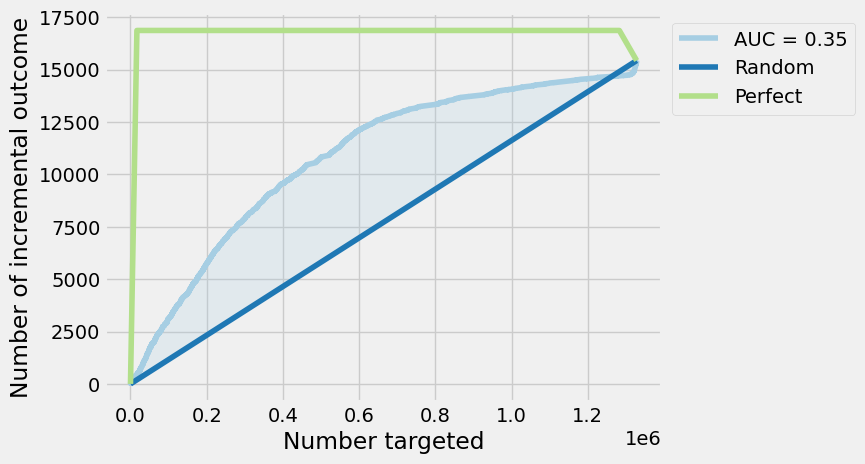

In [86]:
plot_qini_curve(
    y_true=y_test,
    uplift=tau,
    treatment=t_test,
)

<Axes: title={'center': 'Uplift Bins'}, xlabel='Bin', ylabel='Actual Uplift Mean'>

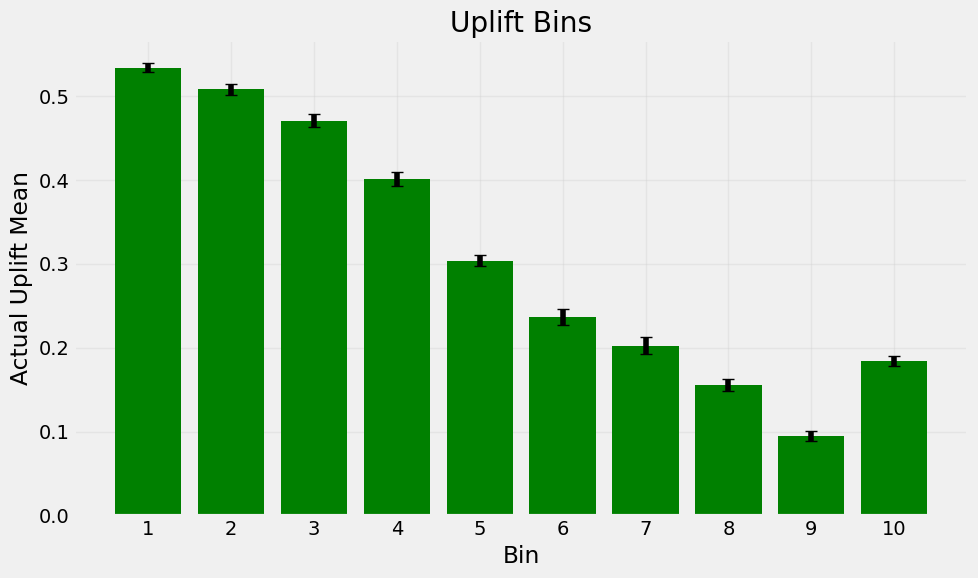

In [87]:
plot_uplift_bins(
    t=t_test,
    y=y_test,
    tau=model_t.predict(X_test).reshape(-1),
)